In [1]:
from word_vectorization import Word2Vec
import matplotlib.pyplot as plt
import tensorflow as tf

To-Do:
- Figure out optimizations (stemming, lematization, stopwords ??) -Adjust batch size? (Also, does each train loop pickup where the other left off? (use % len()))
- Clean wiki dataset by removing extra sections at the end (ie. see also, references)
- Test word2vec embeddings with wiki dataset
- Implement GloVe
- Test GloVe embeddings with wiki dataset
- Implement Intelligent Agent

In [2]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')
with open(path_to_file) as f:
    words = [word for line in f.readlines() for word in line.split()]

print(f'Number of words: {len(words)}')
print(f'First 10 words: {words[:10]}')
print(f"Unique words in Shakespeare Corpus before pre-processing: {len(set(words))}")

Number of words: 202651
First 10 words: ['First', 'Citizen:', 'Before', 'we', 'proceed', 'any', 'further,', 'hear', 'me', 'speak.']
Unique words in Shakespeare Corpus before pre-processing: 25670


In [ ]:
print("SKIP-GRAM MODEL")

test_model = Word2Vec(architecture='skipgram', batch_size=750, num_skips=4, skip_window=2, vocab_size=12000, embedding_size=500, n_steps=100001)
loss_values = test_model.fit(words)

# Plot the loss values
plt.plot(loss_values)
plt.xlabel('Steps (1000s)')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

test_model.eval()

CBOW MODEL

Tokenizing words...

Training model...


Progress: 100%|██████████ | Elapsed: 35:53 | ETA: 00:00 | 46.43it/s, loss=0.643, training cycles=370


Training has completed successfully with a final loss of 0.6431683897972107.



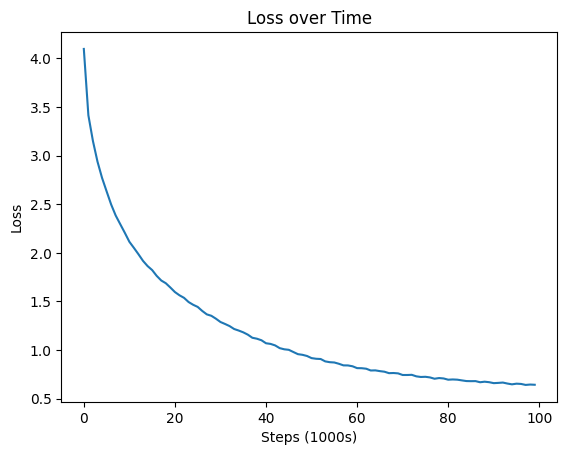


Embedding for 'king': [ 7.13960975e-02  2.24687923e-02  5.20036854e-02  4.26906236e-02
 -5.37373051e-02  2.67645940e-02 -2.35642139e-02  2.76785623e-02
 -5.28232791e-02 -2.44590621e-02  3.75823639e-02  3.38340774e-02
  3.92296687e-02 -3.09258997e-02 -5.99535443e-02 -6.22396022e-02
 -4.86873202e-02  4.13114717e-03 -6.04766272e-02 -2.28883717e-02
  3.42343897e-02 -4.60987464e-02 -5.28368056e-02 -5.90356346e-03
 -3.08176968e-02  6.44905940e-02 -6.15099296e-02  2.71873139e-02
 -7.30494782e-02  2.16579507e-03 -6.93146810e-02  7.52758458e-02
  3.84048931e-03 -4.66636196e-02  3.97786163e-02 -3.86527739e-02
  7.23451097e-03  4.40928303e-02 -1.81199014e-02  6.52116463e-02
  1.40481610e-02 -4.70540449e-02  3.93832475e-02  7.74523318e-02
 -3.73647138e-02 -6.32031113e-02  2.15778640e-03 -5.17132878e-02
  6.11539744e-02  1.73298921e-02  4.78253402e-02 -3.88284288e-02
  1.11617777e-03  2.27447692e-02 -6.78787082e-02 -5.64226136e-02
  6.58355728e-02  3.62584777e-02  6.12342842e-02 -2.91445628e-02
  

In [3]:
print("CBOW MODEL")

test2_model = Word2Vec(architecture='cbow', batch_size=750, num_skips=6, skip_window=3, vocab_size=12000, embedding_size=500, n_steps=100001)
loss_values2 = test2_model.fit(words)

# Plot the loss values
plt.plot(loss_values2)
plt.xlabel('Steps (1000s)')
plt.ylabel('Loss')
plt.title('Loss over Time')
plt.show()

test2_model.eval()

# 1.44

In [ ]:
pickle_file_path = 'Resources\\corpus.pkl'
batch_size = 128
num_skips = 4
skip_window = 2

word2vec = Word2Vec(architecture='cbow', batch_size=batch_size, num_skips=num_skips, skip_window=skip_window)
model = word2vec.fit(pickle_file_path)